# Introduction

Do higher film budgets lead to more box office revenue? Let's find out if there's a relationship using the movie budgets and financial performance data that I've scraped from [the-numbers.com](https://www.the-numbers.com/movie/budgets) on **May 1st, 2018**. 

<img src=https://i.imgur.com/kq7hrEh.png>

# Import Statements

In [1]:
import pandas as pd
import matplotlib.pyplot as plt

import seaborn as sns
from sklearn.linear_model import LinearRegression

# Notebook Presentation

In [2]:
pd.options.display.float_format = '{:,.2f}'.format

from pandas.plotting import register_matplotlib_converters
register_matplotlib_converters()

# Read the Data

In [3]:
data = pd.read_csv('cost_revenue_dirty.csv')

# Explore and Clean the Data

**Challenge**: Answer these questions about the dataset:
1. How many rows and columns does the dataset contain?
2. Are there any NaN values present?
3. Are there any duplicate rows?
4. What are the data types of the columns?

In [4]:
data.shape

(5391, 6)

In [5]:
data.sample(5)

Rank Release_Date  ... USD_Worldwide_Gross USD_Domestic_Gross
417   4283    6/30/1985  ...         $34,004,262         $5,804,262
1076  4128    3/27/1998  ...            $713,413           $713,413
4267  1123   11/16/2012  ...         $71,004,627        $12,816,367
3218  1952    9/19/2008  ...         $45,160,110        $13,848,978
1250  2900    5/21/1999  ...          $8,322,608         $8,322,608

[5 rows x 6 columns]

In [6]:
data.tail()

Rank Release_Date  ... USD_Worldwide_Gross USD_Domestic_Gross
5386  2950    10/8/2018  ...                  $0                 $0
5387   126   12/18/2018  ...                  $0                 $0
5388    96   12/31/2020  ...                  $0                 $0
5389  1119   12/31/2020  ...                  $0                 $0
5390  2517   12/31/2020  ...                  $0                 $0

[5 rows x 6 columns]

In [7]:
print(f'Any NaN values among the data? {data.isna().values.any()}')

Any NaN values among the data? False


In [8]:
print(f'Any duplicates? {data.duplicated().values.any()}')

duplicated_rows = data[data.duplicated()]
print(f'Number of duplicates: {len(duplicated_rows)}')

Any duplicates? False
Number of duplicates: 0


In [9]:
# Show NaN values and data types per column
data.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 5391 entries, 0 to 5390
Data columns (total 6 columns):
 #   Column                 Non-Null Count  Dtype 
---  ------                 --------------  ----- 
 0   Rank                   5391 non-null   int64 
 1   Release_Date           5391 non-null   object
 2   Movie_Title            5391 non-null   object
 3   USD_Production_Budget  5391 non-null   object
 4   USD_Worldwide_Gross    5391 non-null   object
 5   USD_Domestic_Gross     5391 non-null   object
dtypes: int64(1), object(5)
memory usage: 252.8+ KB


### Data Type Conversions

**Challenge**: Convert the `USD_Production_Budget`, `USD_Worldwide_Gross`, and `USD_Domestic_Gross` columns to a numeric format by removing `$` signs and `,`. 
<br>
<br>
Note that *domestic* in this context refers to the United States.

In [10]:
chars_to_remove = [',', '$']
columns_to_clean = ['USD_Production_Budget', 
                    'USD_Worldwide_Gross',
                    'USD_Domestic_Gross']

for col in columns_to_clean:
    for char in chars_to_remove:
        # Replace each character with an empty string
        data[col] = data[col].astype(str).str.replace(char, "")
    # Convert column to a numeric data type
    data[col] = pd.to_numeric(data[col])

In [11]:
data.head()

Rank Release_Date  ... USD_Worldwide_Gross  USD_Domestic_Gross
0  5293     8/2/1915  ...            11000000            10000000
1  5140     5/9/1916  ...                   0                   0
2  5230   12/24/1916  ...             8000000             8000000
3  5299    9/17/1920  ...             3000000             3000000
4  5222     1/1/1925  ...            22000000            11000000

[5 rows x 6 columns]

**Challenge**: Convert the `Release_Date` column to a Pandas Datetime type. 

In [12]:
data.Release_Date = pd.to_datetime(data.Release_Date)
data.head()

Rank Release_Date  ... USD_Worldwide_Gross  USD_Domestic_Gross
0  5293   1915-08-02  ...            11000000            10000000
1  5140   1916-05-09  ...                   0                   0
2  5230   1916-12-24  ...             8000000             8000000
3  5299   1920-09-17  ...             3000000             3000000
4  5222   1925-01-01  ...            22000000            11000000

[5 rows x 6 columns]

In [13]:
data.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 5391 entries, 0 to 5390
Data columns (total 6 columns):
 #   Column                 Non-Null Count  Dtype         
---  ------                 --------------  -----         
 0   Rank                   5391 non-null   int64         
 1   Release_Date           5391 non-null   datetime64[ns]
 2   Movie_Title            5391 non-null   object        
 3   USD_Production_Budget  5391 non-null   int64         
 4   USD_Worldwide_Gross    5391 non-null   int64         
 5   USD_Domestic_Gross     5391 non-null   int64         
dtypes: datetime64[ns](1), int64(4), object(1)
memory usage: 252.8+ KB


### Descriptive Statistics

**Challenge**: 

1. What is the average production budget of the films in the data set?
2. What is the average worldwide gross revenue of films?
3. What were the minimums for worldwide and domestic revenue?
4. Are the bottom 25% of films actually profitable or do they lose money?
5. What are the highest production budget and highest worldwide gross revenue of any film?
6. How much revenue did the lowest and highest budget films make?

In [14]:
data.describe()

Rank  USD_Production_Budget  USD_Worldwide_Gross  USD_Domestic_Gross
count 5,391.00               5,391.00             5,391.00            5,391.00
mean  2,696.00          31,113,737.58        88,855,421.96       41,235,519.44
std   1,556.39          40,523,796.88       168,457,757.00       66,029,346.27
min       1.00               1,100.00                 0.00                0.00
25%   1,348.50           5,000,000.00         3,865,206.00        1,330,901.50
50%   2,696.00          17,000,000.00        27,450,453.00       17,192,205.00
75%   4,043.50          40,000,000.00        96,454,455.00       52,343,687.00
max   5,391.00         425,000,000.00     2,783,918,982.00      936,662,225.00

In [15]:
data[data.USD_Production_Budget == 1100.00]

Rank Release_Date  ... USD_Worldwide_Gross  USD_Domestic_Gross
2427  5391   2005-05-08  ...              181041              181041

[1 rows x 6 columns]

In [16]:
data[data.USD_Production_Budget == 425000000.00]

Rank Release_Date  ... USD_Worldwide_Gross  USD_Domestic_Gross
3529     1   2009-12-18  ...          2783918982           760507625

[1 rows x 6 columns]

# Investigating the Zero Revenue Films

**Challenge** How many films grossed $0 domestically (i.e., in the United States)? What were the highest budget films that grossed nothing?

In [17]:
zero_domestic = data[data.USD_Domestic_Gross == 0]
print(f'Number of films that grossed $0 domestically {len(zero_domestic)}')
zero_domestic.sort_values('USD_Production_Budget', ascending=False)

Number of films that grossed $0 domestically 512


Rank Release_Date  ... USD_Worldwide_Gross  USD_Domestic_Gross
5388    96   2020-12-31  ...                   0                   0
5387   126   2018-12-18  ...                   0                   0
5384   321   2018-09-03  ...                   0                   0
5385   366   2018-10-08  ...                   0                   0
5090   556   2015-12-31  ...             4547660                   0
...    ...          ...  ...                 ...                 ...
4787  5371   2014-12-31  ...                   0                   0
3056  5374   2007-12-31  ...                   0                   0
4907  5381   2015-05-19  ...                   0                   0
5006  5389   2015-09-29  ...                   0                   0
5007  5390   2015-09-29  ...                   0                   0

[512 rows x 6 columns]

**Challenge**: How many films grossed $0 worldwide? What are the highest budget films that had no revenue internationally?

In [18]:
zero_worldwide = data[data.USD_Worldwide_Gross == 0]
print(f'Number of films that grossed $0 worldwide {len(zero_worldwide)}')
zero_worldwide.sort_values('USD_Production_Budget', ascending=False)

Number of films that grossed $0 worldwide 357


Rank Release_Date  ... USD_Worldwide_Gross  USD_Domestic_Gross
5388    96   2020-12-31  ...                   0                   0
5387   126   2018-12-18  ...                   0                   0
5384   321   2018-09-03  ...                   0                   0
5385   366   2018-10-08  ...                   0                   0
5058   880   2015-11-12  ...                   0                   0
...    ...          ...  ...                 ...                 ...
4787  5371   2014-12-31  ...                   0                   0
3056  5374   2007-12-31  ...                   0                   0
4907  5381   2015-05-19  ...                   0                   0
5006  5389   2015-09-29  ...                   0                   0
5007  5390   2015-09-29  ...                   0                   0

[357 rows x 6 columns]

### Filtering on Multiple Conditions

In [19]:
international_releases = data.loc[(data.USD_Domestic_Gross == 0) & 
                                  (data.USD_Worldwide_Gross != 0)]
print(f'Number of international releases: {len(international_releases)}')
international_releases.head()

Number of international releases: 155


Rank Release_Date  ... USD_Worldwide_Gross  USD_Domestic_Gross
71    4310   1956-02-16  ...                3220                   0
1579  5087   2001-02-11  ...                7890                   0
1744  3695   2001-12-31  ...            10834406                   0
2155  4236   2003-12-31  ...               63180                   0
2203  2513   2004-03-31  ...             5918742                   0

[5 rows x 6 columns]

**Challenge**: Use the [`.query()` function](https://pandas.pydata.org/pandas-docs/stable/reference/api/pandas.DataFrame.query.html) to accomplish the same thing. Create a subset for international releases that had some worldwide gross revenue, but made zero revenue in the United States. 

Hint: This time you'll have to use the `and` keyword.

In [20]:
international_releases = data.query('USD_Domestic_Gross == 0 and USD_Worldwide_Gross != 0')
print(f'Number of international releases: {len(international_releases)}')
international_releases.tail()

Number of international releases: 155


Rank Release_Date  ... USD_Worldwide_Gross  USD_Domestic_Gross
5340  1506   2017-04-14  ...             1480089                   0
5348  2225   2017-05-05  ...            58807172                   0
5360  4832   2017-07-03  ...               27561                   0
5372  1856   2017-08-25  ...            48048527                   0
5374  4237   2017-08-25  ...               36630                   0

[5 rows x 6 columns]

### Unreleased Films

**Challenge**:
* Identify which films were not released yet as of the time of data collection (May 1st, 2018).
* How many films are included in the dataset that have not yet had a chance to be screened in the box office? 
* Create another DataFrame called data_clean that does not include these films. 

In [21]:
# Date of Data Collection
scrape_date = pd.Timestamp('2018-5-1')

In [22]:
future_releases = data[data.Release_Date >= scrape_date]
print(f'Number of unreleased movies: {len(future_releases)}')
future_releases

Number of unreleased movies: 7


Rank Release_Date  ... USD_Worldwide_Gross  USD_Domestic_Gross
5384   321   2018-09-03  ...                   0                   0
5385   366   2018-10-08  ...                   0                   0
5386  2950   2018-10-08  ...                   0                   0
5387   126   2018-12-18  ...                   0                   0
5388    96   2020-12-31  ...                   0                   0
5389  1119   2020-12-31  ...                   0                   0
5390  2517   2020-12-31  ...                   0                   0

[7 rows x 6 columns]

In [23]:
# exclude future releases
data_clean = data.drop(future_releases.index)

In [24]:
# difference is 7 rows
data.shape[0] - data_clean.shape[0]

7

### Films that Lost Money

**Challenge**: 
What is the percentage of films where the production costs exceeded the worldwide gross revenue? 

In [25]:
money_losing = data_clean.loc[data_clean.USD_Production_Budget > data_clean.USD_Worldwide_Gross]
len(money_losing)/len(data_clean)

0.37277117384843983

In [26]:
money_losing = data_clean.query('USD_Production_Budget > USD_Worldwide_Gross')
money_losing.shape[0]/data_clean.shape[0]

0.37277117384843983

# Seaborn for Data Viz: Bubble Charts

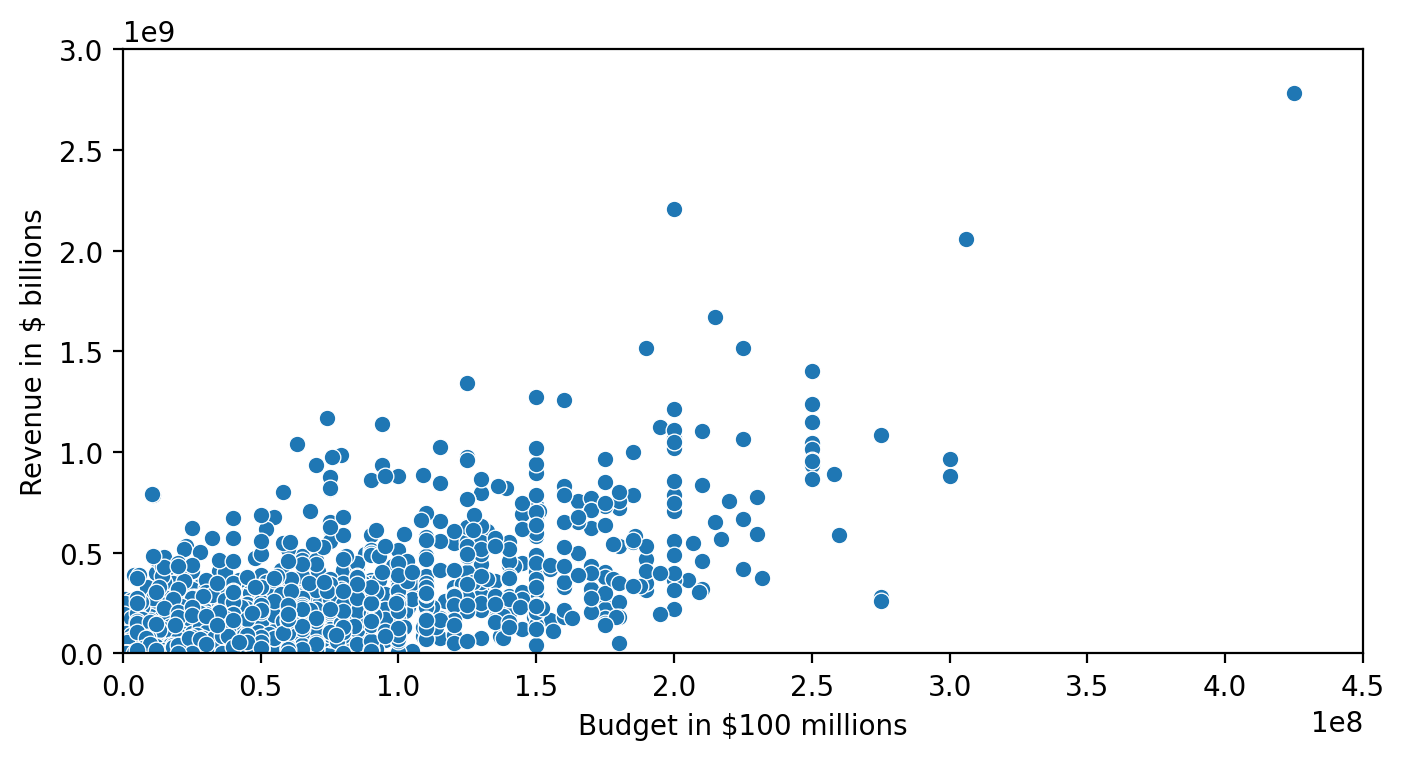

In [27]:
plt.figure(figsize=(8,4), dpi=200)

ax = sns.scatterplot(data=data_clean,
                     x='USD_Production_Budget', 
                     y='USD_Worldwide_Gross')

ax.set(ylim=(0, 3000000000),
       xlim=(0, 450000000),
       ylabel='Revenue in $ billions',
       xlabel='Budget in $100 millions')

plt.show()

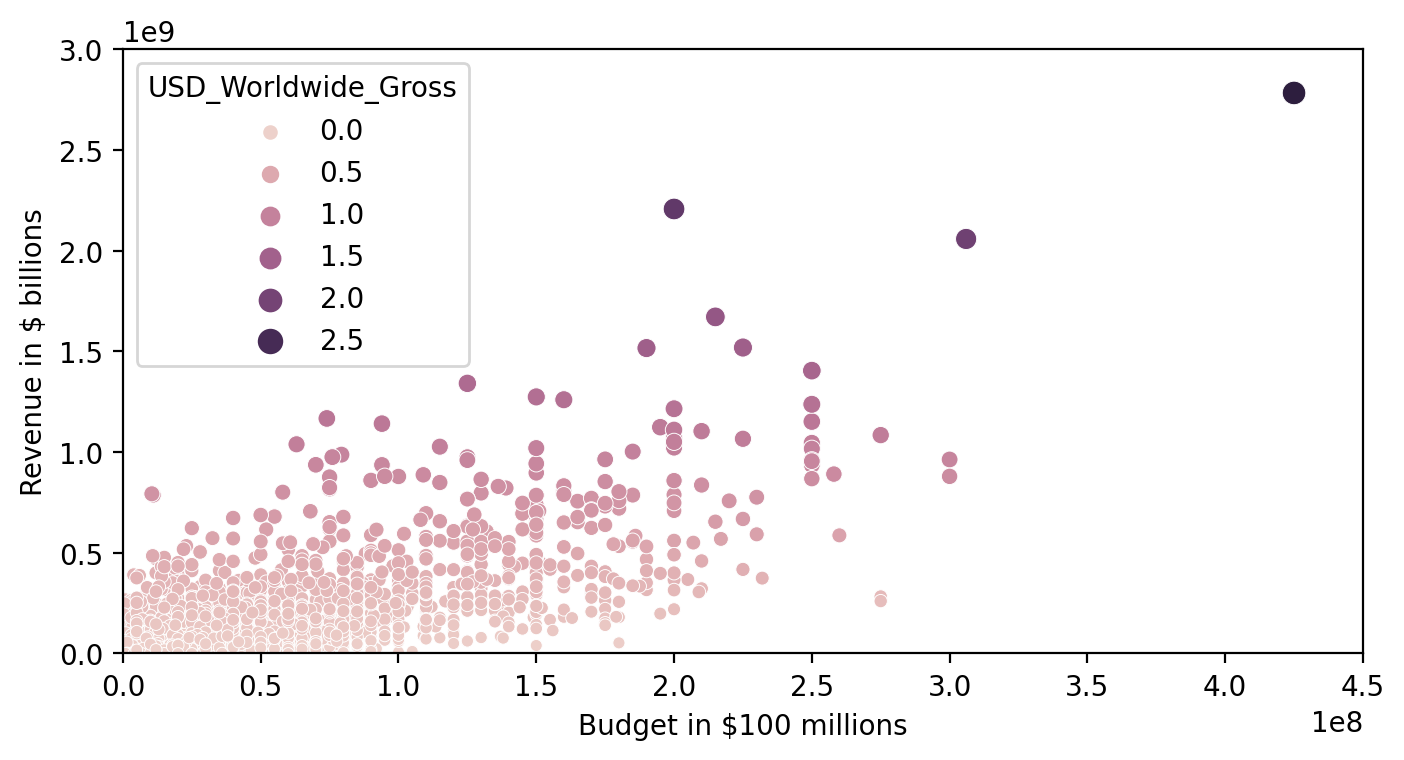

In [28]:
plt.figure(figsize=(8,4), dpi=200)
ax = sns.scatterplot(data=data_clean,
                     x='USD_Production_Budget', 
                     y='USD_Worldwide_Gross',
                     hue='USD_Worldwide_Gross', # change colour
                     size='USD_Worldwide_Gross',) # change size of dot

ax.set(ylim=(0, 3000000000),
       xlim=(0, 450000000),
       ylabel='Revenue in $ billions',
       xlabel='Budget in $100 millions',)

plt.show()

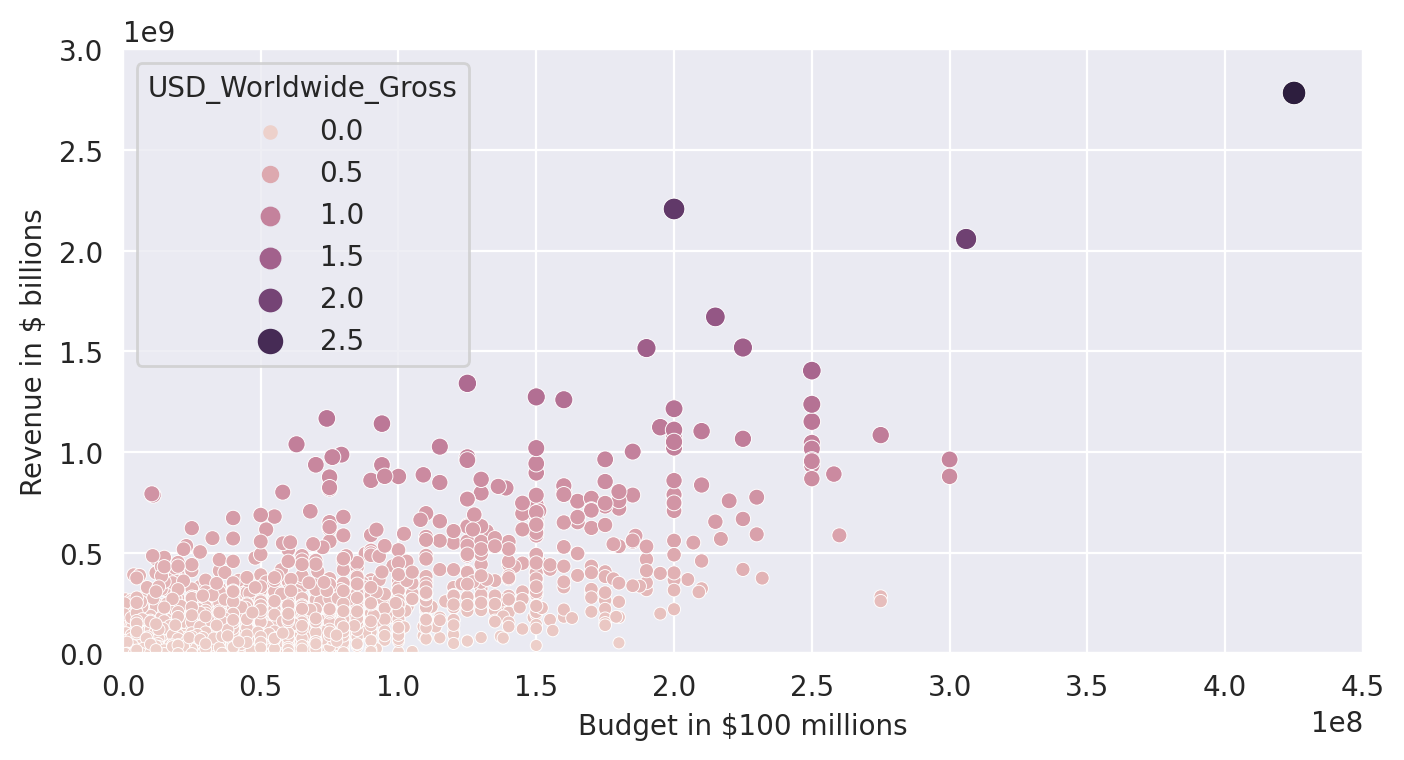

In [29]:
plt.figure(figsize=(8,4), dpi=200)

# set styling on a single chart
with sns.axes_style('darkgrid'):
  ax = sns.scatterplot(data=data_clean,
                       x='USD_Production_Budget', 
                       y='USD_Worldwide_Gross',
                       hue='USD_Worldwide_Gross',
                       size='USD_Worldwide_Gross')

  ax.set(ylim=(0, 3000000000),
        xlim=(0, 450000000),
        ylabel='Revenue in $ billions',
        xlabel='Budget in $100 millions')

### Plotting Movie Releases over Time

**Challenge**: Try to create the following Bubble Chart:

<img src=https://i.imgur.com/8fUn9T6.png>



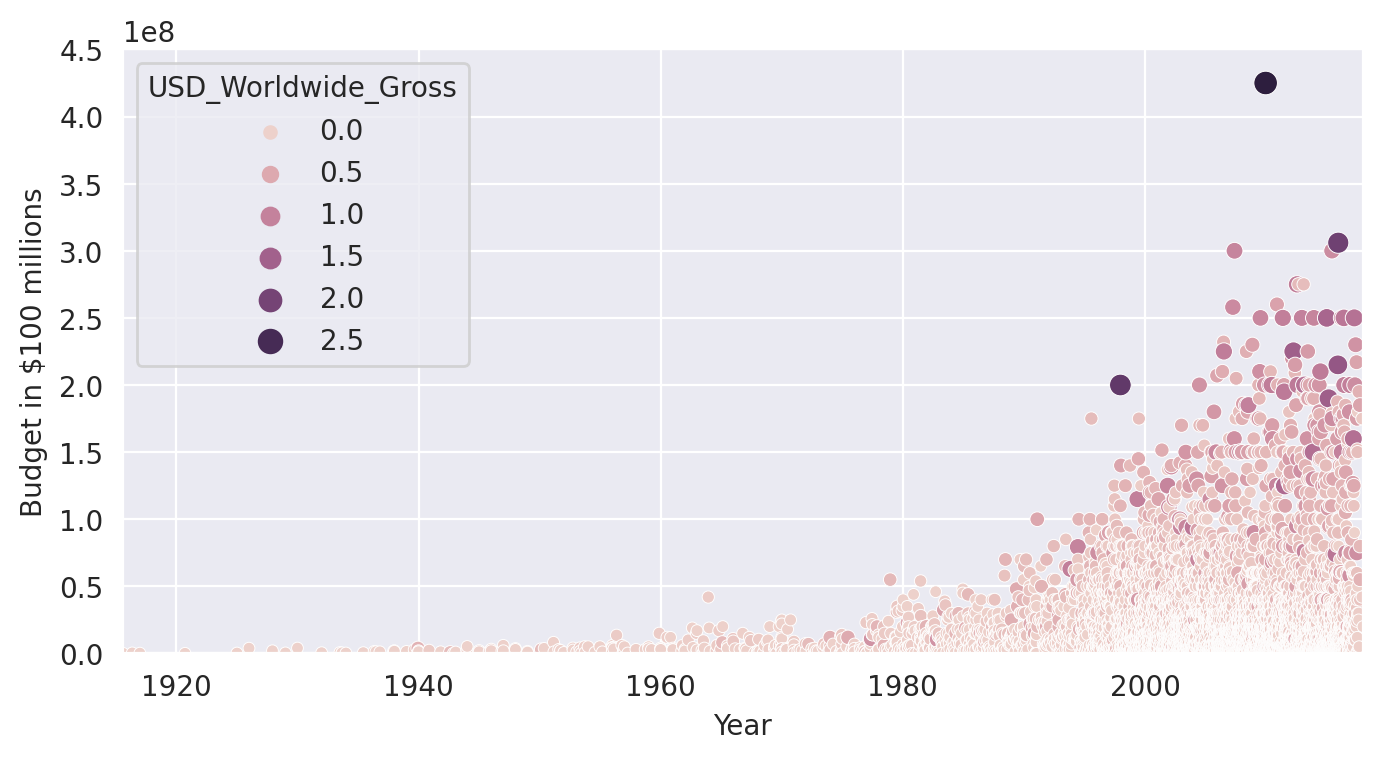

In [30]:
plt.figure(figsize=(8,4), dpi=200)

with sns.axes_style("darkgrid"):
    ax = sns.scatterplot(data=data_clean, 
                    x='Release_Date', 
                    y='USD_Production_Budget',
                    hue='USD_Worldwide_Gross',
                    size='USD_Worldwide_Gross',)

    ax.set(ylim=(0, 450000000),
           xlim=(data_clean.Release_Date.min(), data_clean.Release_Date.max()),
           xlabel='Year',
           ylabel='Budget in $100 millions')


# Converting Years to Decades Trick

**Challenge**: Create a column in `data_clean` that has the decade of the release. 

<img src=https://i.imgur.com/0VEfagw.png width=650> 

Here's how: 
1. Create a [`DatetimeIndex` object](https://pandas.pydata.org/pandas-docs/stable/reference/api/pandas.DatetimeIndex.html) from the Release_Date column. 
2. Grab all the years from the `DatetimeIndex` object using the `.year` property.
<img src=https://i.imgur.com/5m06Ach.png width=650>
3. Use floor division `//` to convert the year data to the decades of the films.
4. Add the decades as a `Decade` column to the `data_clean` DataFrame.

In [31]:
dt_index = pd.DatetimeIndex(data_clean.Release_Date)
years = dt_index.year

In [32]:
# How to convert the year 1999 to the 90s decade
1999//10

199

In [33]:
199*10

1990

In [34]:
decades = years//10*10
data_clean['Decade'] = decades

### Separate the "old" (before 1969) and "New" (1970s onwards) Films

**Challenge**: Create two new DataFrames: `old_films` and `new_films`
* `old_films` should include all the films before 1969 (up to and including 1969)
* `new_films` should include all the films from 1970 onwards
* How many films were released prior to 1970?
* What was the most expensive film made prior to 1970?

In [35]:
old_films = data_clean[data_clean.Decade <= 1960]
new_films = data_clean[data_clean.Decade > 1960]

In [36]:
old_films.describe()

Rank  USD_Production_Budget  ...  USD_Domestic_Gross   Decade
count   153.00                 153.00  ...              153.00   153.00
mean  4,274.77           4,611,297.65  ...       22,389,473.87 1,949.15
std     742.14           5,713,648.85  ...       32,641,752.41    12.72
min   1,253.00             100,000.00  ...                0.00 1,910.00
25%   3,973.00           1,250,000.00  ...        5,000,000.00 1,940.00
50%   4,434.00           2,900,000.00  ...       10,000,000.00 1,950.00
75%   4,785.00           5,000,000.00  ...       28,350,000.00 1,960.00
max   5,299.00          42,000,000.00  ...      198,680,470.00 1,960.00

[8 rows x 5 columns]

In [37]:
old_films.sort_values('USD_Production_Budget', ascending=False).head()

Rank Release_Date  ... USD_Domestic_Gross  Decade
109  1253   1963-12-06  ...           57000000    1960
150  2175   1969-12-16  ...           33208099    1960
143  2465   1969-01-01  ...            8000000    1960
118  2425   1965-02-15  ...           15473333    1960
148  2375   1969-10-15  ...           31678778    1960

[5 rows x 7 columns]

# Seaborn Regression Plots

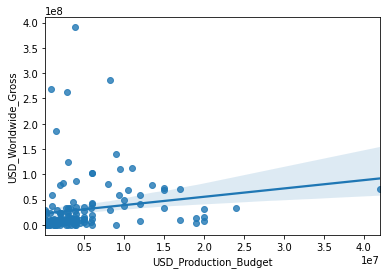

In [38]:
sns.regplot(data=old_films, 
            x='USD_Production_Budget',
            y='USD_Worldwide_Gross')

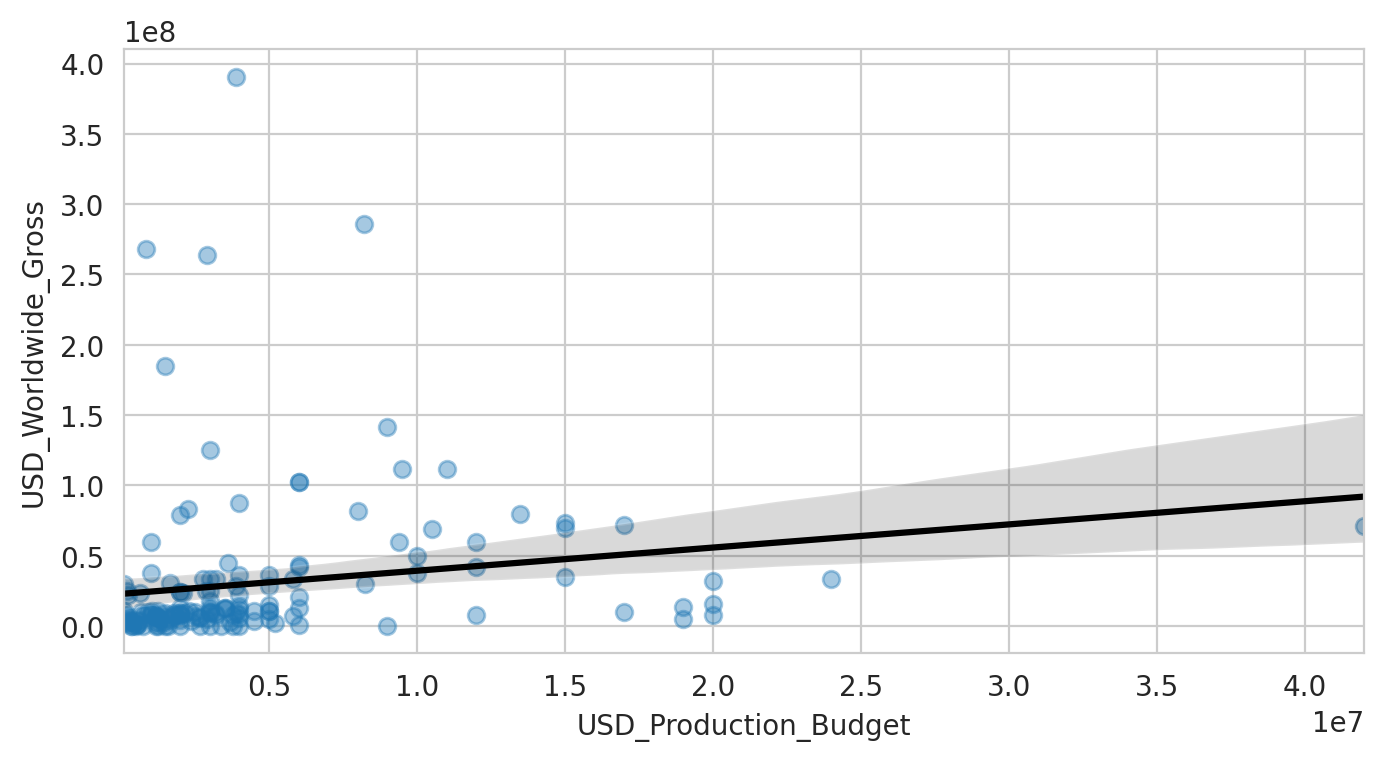

In [39]:
plt.figure(figsize=(8,4), dpi=200)
with sns.axes_style("whitegrid"):
  sns.regplot(data=old_films, 
            x='USD_Production_Budget', 
            y='USD_Worldwide_Gross',
            scatter_kws = {'alpha': 0.4},
            line_kws = {'color': 'black'})

**Challenge**: Use Seaborn's `.regplot()` to show the scatter plot and linear regression line against the `new_films`. 
<br>
<br>
Style the chart

* Put the chart on a `'darkgrid'`.
* Set limits on the axes so that they don't show negative values.
* Label the axes on the plot "Revenue in \$ billions" and "Budget in \$ millions".
* Provide HEX colour codes for the plot and the regression line. Make the dots dark blue (#2f4b7c) and the line orange (#ff7c43).

Interpret the chart

* Do our data points for the new films align better or worse with the linear regression than for our older films?
* Roughly how much would a film with a budget of $150 million make according to the regression line?

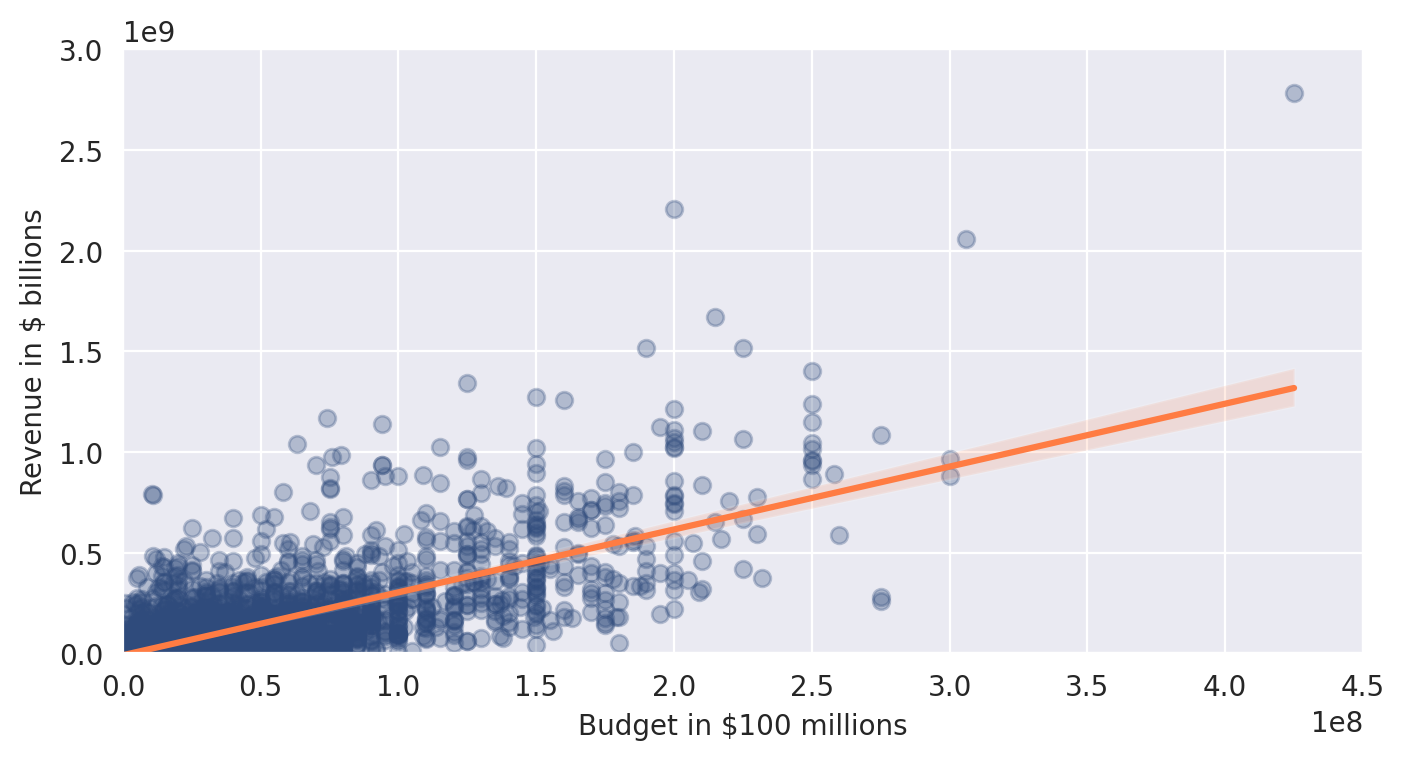

In [40]:
plt.figure(figsize=(8,4), dpi=200)
with sns.axes_style('darkgrid'):
  ax = sns.regplot(data=new_films,
                   x='USD_Production_Budget',
                   y='USD_Worldwide_Gross',
                   color='#2f4b7c',
                   scatter_kws = {'alpha': 0.3},
                   line_kws = {'color': '#ff7c43'})
  
  ax.set(ylim=(0, 3000000000),
         xlim=(0, 450000000),
         ylabel='Revenue in $ billions',
         xlabel='Budget in $100 millions')

# Run Your Own Regression with scikit-learn

Our Linear Model:

$$ REV \hat ENUE = \theta _0 + \theta _1 BUDGET$$

In [41]:
# Create regression object
regression = LinearRegression()

In [42]:
# Explanatory Variable(s) or Feature(s)
X = pd.DataFrame(new_films, columns=['USD_Production_Budget'])

# Response Variable or Target
y = pd.DataFrame(new_films, columns=['USD_Worldwide_Gross'])

In [43]:
# Find the best-fit line
regression.fit(X, y)

LinearRegression(copy_X=True, fit_intercept=True, n_jobs=None, normalize=False)

In [44]:
# Theta zero
regression.intercept_

array([-8650768.00661027])

In [45]:
# Theta one
regression.coef_

array([[3.12259592]])

In [46]:
# R-squared
regression.score(X, y)

0.5577032617720403

**Challenge**: Run a linear regression for the `old_films`. Calculate the intercept, slope and r-squared. How much of the variance in movie revenue does the linear model explain in this case?

In [47]:
X = pd.DataFrame(old_films, columns=['USD_Production_Budget'])
y = pd.DataFrame(old_films, columns=['USD_Worldwide_Gross'])
regression.fit(X, y)
print(f'The slope coefficient is: {regression.coef_[0]}')
print(f'The intercept is: {regression.intercept_[0]}')
print(f'The r-squared is: {regression.score(X, y)}')

The slope coefficient is: [1.64771314]
The intercept is: 22821538.635080386
The r-squared is: 0.02937258620576877


# Use Your Model to Make a Prediction

We just estimated the slope and intercept! Remember that our Linear Model has the following form:

$$ REV \hat ENUE = \theta _0 + \theta _1 BUDGET$$

**Challenge**:  How much global revenue does our model estimate for a film with a budget of $350 million? 

In [70]:
22821538 + 1.64771314 * 350000000

599521137.0

In [71]:
budget = 350000000
revenue_estimate = regression.intercept_[0] + regression.coef_[0,0]*budget
revenue_estimate = round(revenue_estimate, -6)
print(f'The estimated revenue for a $350 film is around ${revenue_estimate:.10}.')

The estimated revenue for a $350 film is around $600000000.0.
